In [2]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import statsmodels.api as sm
plt.style.use('fivethirtyeight')
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.metrics import mean_squared_error

df_basinc = pd.read_csv('/Users/ardahanaytan/Desktop/STAJ/Hava Durumu Tahmin Projesi/data/weather_datas/basinc.csv')
df_bulut = pd.read_csv('/Users/ardahanaytan/Desktop/STAJ/Hava Durumu Tahmin Projesi/data/weather_datas/bulut.csv')
df_nem = pd.read_csv('/Users/ardahanaytan/Desktop/STAJ/Hava Durumu Tahmin Projesi/data/weather_datas/nem.csv')
df_ruzgar = pd.read_csv('/Users/ardahanaytan/Desktop/STAJ/Hava Durumu Tahmin Projesi/data/weather_datas/ruzgar.csv')
df_sicaklik = pd.read_csv('/Users/ardahanaytan/Desktop/STAJ/Hava Durumu Tahmin Projesi/data/weather_datas/sicaklik.csv')
df_yagmur = pd.read_csv('/Users/ardahanaytan/Desktop/STAJ/Hava Durumu Tahmin Projesi/data/weather_datas/yagmur.csv')
df_kar = pd.read_csv('/Users/ardahanaytan/Desktop/STAJ/Hava Durumu Tahmin Projesi/data/weather_datas/kar.csv')

tables = [df_nem, df_ruzgar, df_sicaklik, df_yagmur, df_kar]
df = pd.merge(df_basinc, df_bulut, on=['Zaman'])
for i in tables:
    df = pd.merge(df, i, on=['Zaman'])

df = df.dropna()
df['Yil'] = df['Zaman'].str[:4].astype(int)
df['Ay'] = df['Zaman'].str[4:6].astype(int)
df['Gun'] = df['Zaman'].str[6:8].astype(int)
df['Saat'] = df['Zaman'].str[9:].str[:2].astype(int)
#df['Zaman'] = df[['Yil', 'Ay', 'Gun']].astype(str).agg('-'.join, axis=1)
df['datetime'] = pd.to_datetime(df[['Yil', 'Ay', 'Gun']].astype(str).agg('-'.join, axis=1) + ' ' + 
                                df['Saat'].astype(str), format='%Y-%m-%d %H')
df.set_index('datetime', inplace=True)
df.drop(columns=['Zaman', 'Yil', 'Ay', 'Gun', 'Saat'], inplace=True)


df.head()

,Basinc,Bulut,Nem,Ruzgar_Hizi,Ruzgar_Yonu,Sicaklik,Yagmur,Kar
datetime,,,,,,,,
1994-01-01 00:00:00,1006.0,97.0,91.332990,9.339208,207.55281,6.840245,0.6,0.0
1994-01-01 01:00:00,1005.1,99.0,90.645615,6.489992,213.69006,6.980245,1.1,0.0
1994-01-01 02:00:00,1005.3,100.0,92.565414,7.235910,264.28943,6.110245,2.2,0.0
1994-01-01 03:00:00,1006.0,100.0,96.283560,13.684735,296.56506,4.990245,2.3,0.0
1994-01-01 04:00:00,1008.5,100.0,92.844430,17.227420,296.02960,4.500246,1.2,0.0


In [213]:
df_t = pd.DataFrame({'Nem': df['Nem']})
train_df = df_t[:'2021'].resample('M').mean()
test_df = df_t['2022':].resample('M').mean()

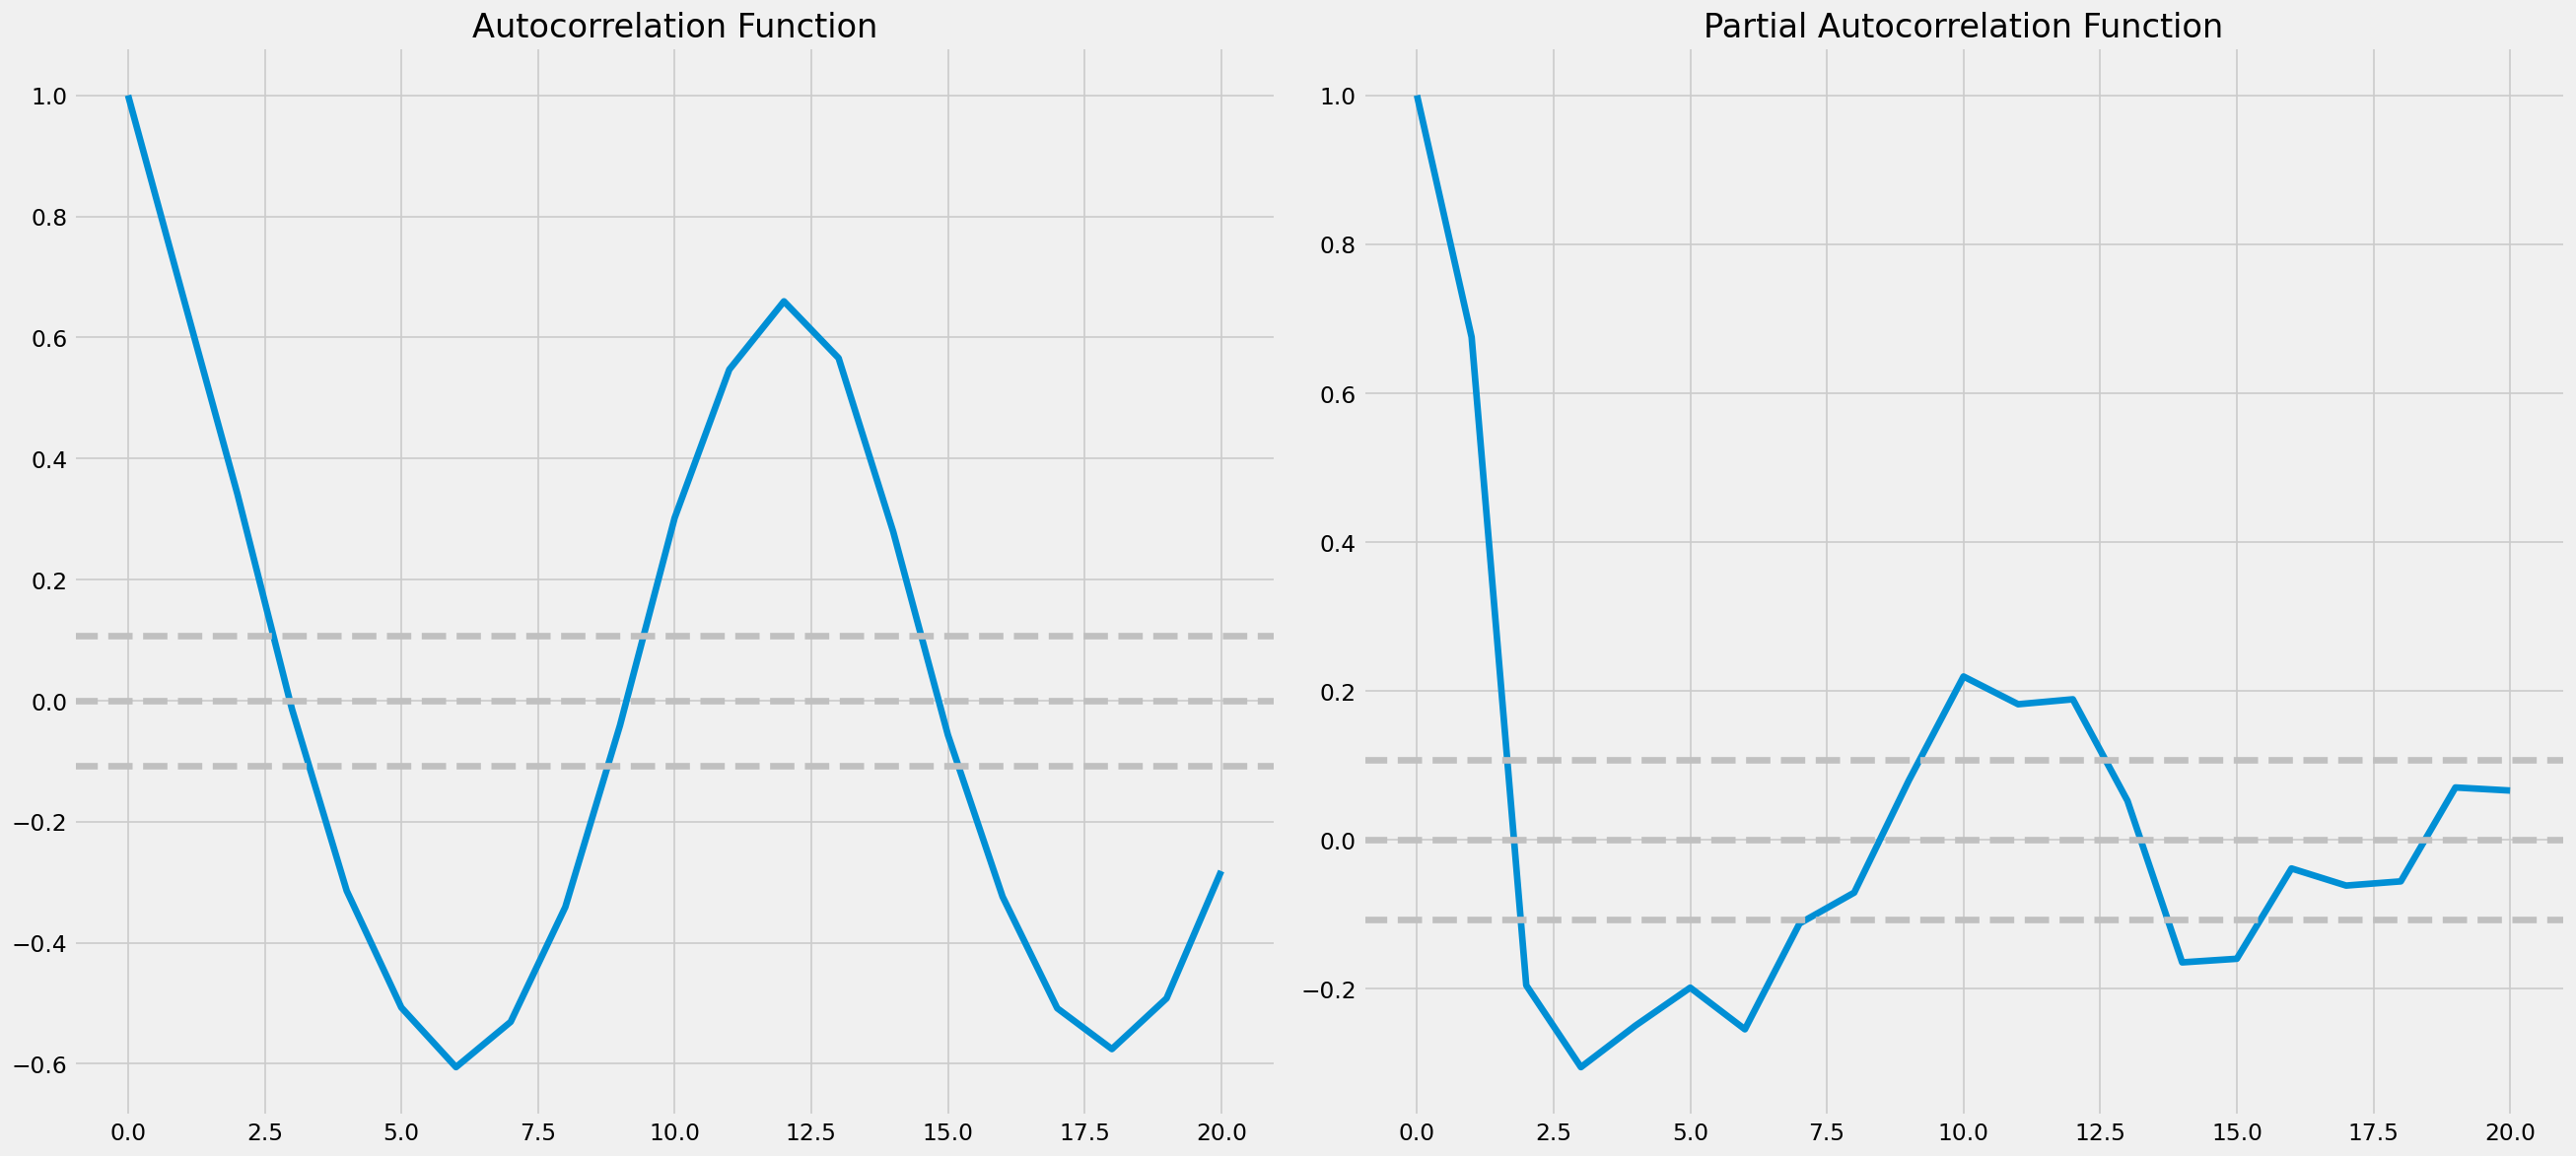

In [214]:
acf_lag = acf(train_df.values, nlags=20)
pacf_lag = pacf(train_df.values, nlags=20, method='ols')

plt.figure(figsize=(22,10))

plt.subplot(1,2,1)
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.title("Autocorrelation Function")

plt.subplot(1,2,2)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

In [215]:
model = ARIMA(train_df.values, order=(2,0,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  336
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1001.101
Date:                Thu, 05 Sep 2024   AIC                           2014.203
Time:                        14:06:36   BIC                           2037.105
Sample:                             0   HQIC                          2023.332
                                - 336                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         76.8443      0.334    230.394      0.000      76.191      77.498
ar.L1          1.7328      0.001   1974.251      0.000       1.731       1.735
ar.L2         -0.9998      0.000  -2045.722      0.0

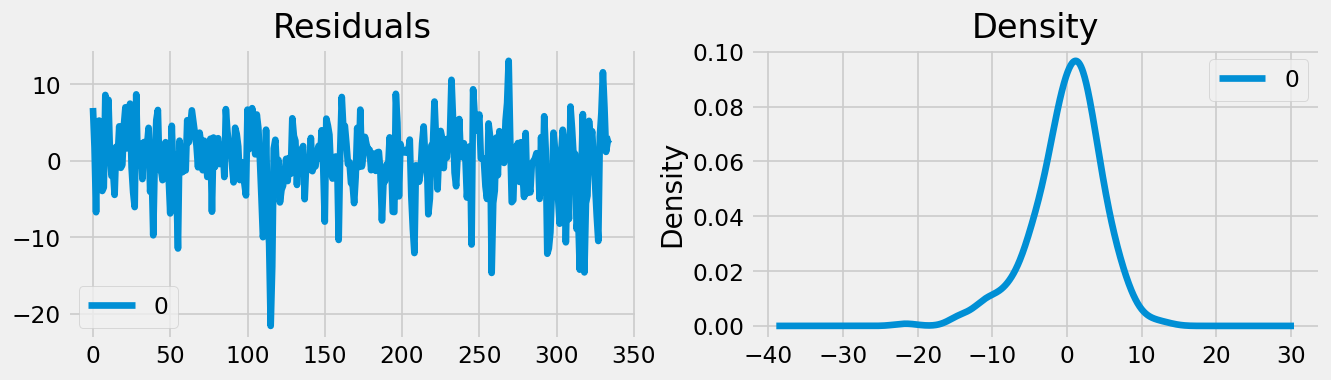

In [216]:
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

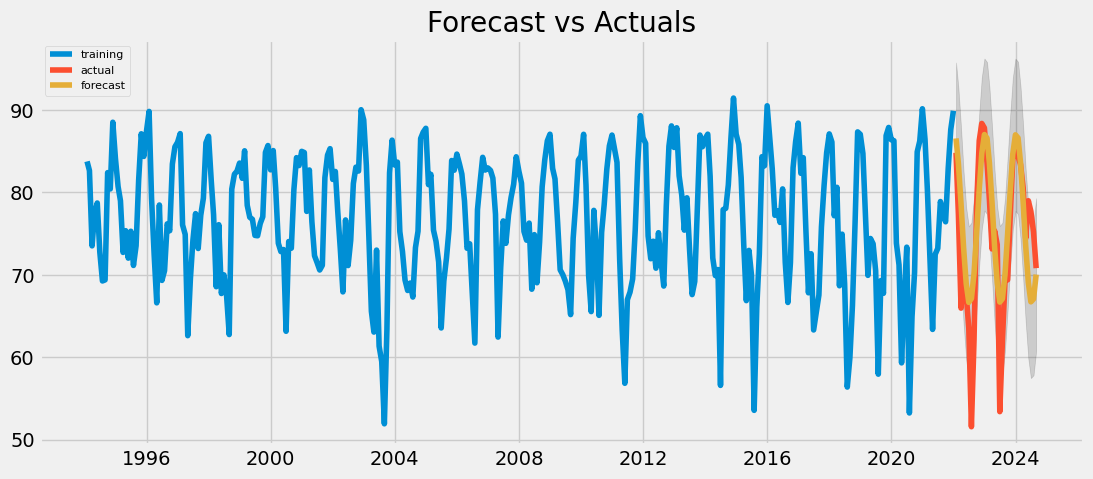

In [217]:
#fc, se, conf = model_fit.forecast(16, alpha=0.05)
forecast_obj = model_fit.get_forecast(steps=32)

fc = forecast_obj.predicted_mean
se = forecast_obj.se_mean
conf = forecast_obj.conf_int(alpha=0.05)

fc_series = pd.Series(fc, index=test_df.index)
lower_series = pd.Series(conf[:, 0], index=test_df.index)
upper_series = pd.Series(conf[:, 1], index=test_df.index)

# # Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_df, label='training')
plt.plot(test_df, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

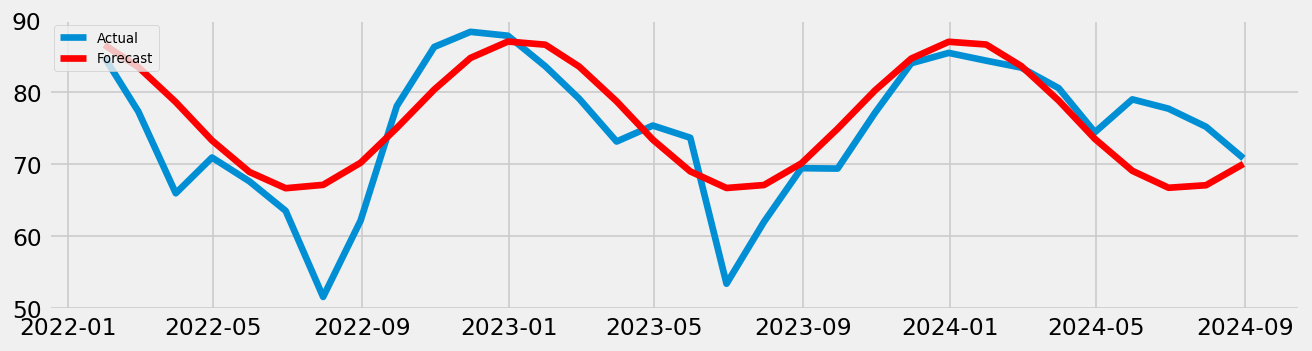

In [218]:
plt.plot(test_df, label='Actual')
plt.plot(fc_series, label='Forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [219]:
error = mean_absolute_error(test_df, fc_series)
print('Test Mean Squared Error: ',error)

Test Mean Squared Error:  4.651706314207258


--------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------

-------------------------------------------

In [66]:
df_ya['max'].min()

984.3

In [92]:
df_y = pd.DataFrame(df['Basinc'])
df_y.head()

,Basinc
datetime,
1994-01-01 00:00:00,1006.0
1994-01-01 01:00:00,1005.1
1994-01-01 02:00:00,1005.3
1994-01-01 03:00:00,1006.0
1994-01-01 04:00:00,1008.5


In [93]:
df_max = df_y.resample('D').max()
df_max.rename(columns = {'Basinc': 'max'}, inplace=True)
df_min = df_y.resample('D').min()
df_min.rename(columns = {'Basinc': 'min'}, inplace=True)
df_top = df_y.resample('D').sum()
df_top.rename(columns = {'Basinc': 'sum'}, inplace=True)
df_ort = df_y.resample('D').mean()
df_ort.rename(columns = {'Basinc': 'mean'}, inplace=True)
df_top.head()

,sum
datetime,
1994-01-01,24375.6
1994-01-02,24224.9
1994-01-03,24180.6
1994-01-04,24105.5
1994-01-05,24030.8


In [94]:
df_ya = pd.concat([df_top, df_ort, df_max, df_min], axis=1)
df_ya.head()

,sum,mean,max,min
datetime,,,,
1994-01-01,24375.6,1015.650000,1021.5,1005.1
1994-01-02,24224.9,1009.370833,1019.1,1004.7
1994-01-03,24180.6,1007.525000,1012.1,1001.0
1994-01-04,24105.5,1004.395833,1005.5,1002.4
1994-01-05,24030.8,1001.283333,1006.5,994.3


In [95]:
df_ya['target'] = df_ya.shift(-1)['max']
df_ya

,sum,mean,max,min,target
datetime,,,,,
1994-01-01,24375.6,1015.650000,1021.5,1005.1,1019.1
1994-01-02,24224.9,1009.370833,1019.1,1004.7,1012.1
1994-01-03,24180.6,1007.525000,1012.1,1001.0,1005.5
1994-01-04,24105.5,1004.395833,1005.5,1002.4,1006.5
1994-01-05,24030.8,1001.283333,1006.5,994.3,993.9
...,...,...,...,...,...
2024-08-21,24453.0,1018.875000,1020.8,1015.4,1019.0
2024-08-22,24367.8,1015.325000,1019.0,1012.6,1015.6
2024-08-23,24341.8,1014.241667,1015.6,1013.4,1015.6


In [96]:
df_ya = df_ya.iloc[:-1,:].copy()
df_ya

,sum,mean,max,min,target
datetime,,,,,
1994-01-01,24375.6,1015.650000,1021.5,1005.1,1019.1
1994-01-02,24224.9,1009.370833,1019.1,1004.7,1012.1
1994-01-03,24180.6,1007.525000,1012.1,1001.0,1005.5
1994-01-04,24105.5,1004.395833,1005.5,1002.4,1006.5
1994-01-05,24030.8,1001.283333,1006.5,994.3,993.9
...,...,...,...,...,...
2024-08-20,24333.3,1013.887500,1015.7,1011.8,1020.8
2024-08-21,24453.0,1018.875000,1020.8,1015.4,1019.0
2024-08-22,24367.8,1015.325000,1019.0,1012.6,1015.6


In [97]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

reg = Ridge(alpha=.1)
predictors = ['sum', 'mean', 'max', 'min']
train = df_ya.loc[:'2021-12-31']
test = df_ya.loc['2022-01-01':]
reg.fit(train[predictors], train['target'])
predictions = reg.predict(test[predictors])
#predictions -= 1.5
mean_absolute_error(test['target'], predictions)

3.1344508952811934

In [98]:
combined = pd.concat([test['target'], pd.Series(predictions, index=test.index)], axis=1)
combined.columns = ['actual', 'predictions']
combined

,actual,predictions
datetime,,
2022-01-01,1025.5,1027.396994
2022-01-02,1022.7,1025.672740
2022-01-03,1009.8,1018.123009
2022-01-04,1018.2,1012.973288
2022-01-05,1023.2,1016.163821
...,...,...
2024-08-20,1020.8,1016.424497
2024-08-21,1019.0,1019.508713
2024-08-22,1015.6,1019.642024


In [ ]:
#combined['predictions'] -= combined['predictions'].min()
combined.plot()

In [ ]:
reg.coef_

In [280]:
def create_predictions(predictors, core_weather, reg):
    train = df_ya.loc[:'2021-12-31']
    test = df_ya.loc['2022-01-01':]
    reg.fit(train[predictors], train['target'])
    predictions = reg.predict(test[predictors])
    error = mean_absolute_error(test['target'], predictions)
    combined = pd.concat([test['target'], pd.Series(predictions, index=test.index)], axis=1)
    combined.columns = ['actual', 'predictions']
    return error, combined

In [281]:
combined['predictions'].min()

165.45561122824003

In [35]:
df_ya['month_max'] = df_ya['max'].rolling(30).mean()
df_ya['month_day_max'] = df_ya['month_max'] / df_ya['max']
df_ya['max_min'] = df_ya['max'] / df_ya['min']
df_ya = df_ya.iloc[30:,:].copy()
predictors = ['mean', 'max', 'min', 'month_max', 'month_day_max', 'max_min']
error, combined = create_predictions(predictors, df_ya, reg)
print(error)
combined.plot()

NameError: name 'create_predictions' is not defined

In [5]:
df_y.tail()

,Ruzgar_Yonu
datetime,
2024-08-25 19:00:00,188.130100
2024-08-25 20:00:00,225.000000
2024-08-25 21:00:00,11.309921
2024-08-25 22:00:00,31.607498
2024-08-25 23:00:00,18.434952


In [87]:
combined.tail()

,actual,predictions
datetime,,
2024-08-20,1020.8,1016.424497
2024-08-21,1019.0,1019.508713
2024-08-22,1015.6,1019.642024
2024-08-23,1015.6,1017.154847
2024-08-24,1024.1,1015.358487


In [101]:
empty_data = {col: ['' for _ in range(7)] for col in combined.columns}
empty_df = pd.DataFrame(empty_data)

# Concatenate the original DataFrame with the empty DataFrame
combined = pd.concat([combined, empty_df], ignore_index=True)
combined.tail()

,actual,predictions
976,,
977,,
978,,
979,,
980,,


In [100]:
combined.tail(10)

,actual,predictions
2024-08-22 00:00:00,1015.6,1019.642024
2024-08-23 00:00:00,1015.6,1017.154847
2024-08-24 00:00:00,1024.1,1015.358487
0,,
1,,
2,,
3,,
4,,
5,,
6,,
